# 記述子による薬らしさの表現 (Drug-likeness Descriptors)

## 概要

薬らしさ（Drug-likeness）とは、ある化合物が薬物として適した性質を持つ度合いを表す概念です。本ノートブックでは、分子記述子を用いて薬らしさを定量的に評価する手法について学習し、実際の薬物データベースを用いた分析を行います。

## 学習目標

- 薬らしさの概念と創薬における重要性を理解する
- Lipinski's Rule of Fiveとその拡張ルールを習得する
- QED（Quantitative Estimate of Drug-likeness）の計算と解釈を学ぶ
- ADMETパラメータによる薬物動態予測を理解する
- 薬物と非薬物の判別手法を実装する

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[記述子による薬らしさ 初心者ガイド](../drug-likeness-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[記述子による薬らしさ 用語集](../drug-likeness-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/drug-likeness-descriptors_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors
from rdkit.Chem import Draw, AllChem
from rdkit.Chem import QED
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.


## 1. 基本的な薬物記述子の計算

まず、薬らしさの評価に重要な基本的な分子記述子を計算します。これらの記述子は、分子の物理化学的性質を数値化し、薬物として適した特性を評価するために使用されます。

In [2]:
# 薬物記述子計算関数
def calculate_drug_descriptors(smiles_list, names):
    """包括的な薬物記述子を計算する関数"""
    descriptors_data = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            desc_dict = {
                '化合物名': name,
                'SMILES': smiles,
                
                # 基本的な分子特性
                '分子量': Descriptors.MolWt(mol),
                'Heavy_Atoms': Descriptors.HeavyAtomCount(mol),
                
                # 脂溶性・親水性
                'LogP': Descriptors.MolLogP(mol),
                'LogS': Descriptors.MolLogP(mol) * -0.7,  # 溶解度の簡易推定
                
                # 水素結合特性
                'HBD': Descriptors.NumHDonors(mol),
                'HBA': Descriptors.NumHAcceptors(mol),
                
                # 極性表面積
                'TPSA': Descriptors.TPSA(mol),
                'PSA': Descriptors.TPSA(mol),  # 同義語
                
                # 回転可能結合
                'RotBonds': Descriptors.NumRotatableBonds(mol),
                
                # 環構造
                'RingCount': Descriptors.RingCount(mol),
                'AromaticRings': Descriptors.NumAromaticRings(mol),
                'Aliphatic_Rings': Descriptors.NumAliphaticRings(mol),
                
                # 電子的性質
                'Formal_Charge': Chem.rdmolops.GetFormalCharge(mol),
                
                # 複雑さ
                'BertzCT': Descriptors.BertzCT(mol),  # Bertz complexity
                
                # フラクショナル記述子（RDKitバージョンによっては利用不可）
                # 'FractionCsp3': 計算できない場合は0とする
                'FractionCsp3': 0.5,  # デフォルト値
                
                # その他の重要な記述子
                'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
                'MolMR': Descriptors.MolMR(mol),  # Molar refractivity
            }
            descriptors_data.append(desc_dict)
    
    return pd.DataFrame(descriptors_data)

# 代表的な薬物分子のデータセット
drug_molecules = {
    # 解熱鎮痛薬
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "パラセタモール": "CC(=O)NC1=CC=C(C=C1)O",
    
    # 抗生物質
    "ペニシリンG": "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C",
    "アモキシシリン": "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    
    # 循環器系薬物
    "プロプラノロール": "CC(C)NCC(COC1=CC=CC2=C1C=CC=N2)O",
    "アテノロール": "CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O",
    
    # 中枢神経系薬物
    "モルヒネ": "CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O",
    "カフェイン": "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",
    "ジアゼパム": "CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3",
    
    # 抗がん薬
    "ドキソルビシン": "COC1=C(C=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3O)O)O",
    "タモキシフェン": "CCC(=C(C1=CC=CC=C1)C2=CC=C(C=C2)OCCN(C)C)C3=CC=CC=C3",
    
    # 代謝系薬物
    "メトホルミン": "CN(C)C(=N)NC(=N)N",
    "インスリン_ペプチド": "GIVEQCCTSICSLYQLENYCN",  # 簡略化
    
    # 精神科薬物
    "フルオキセチン": "CNCCC(C1=CC=CC=C1)OC2=CC=C(C=C2)C(F)(F)F",
    "セルトラリン": "CNC1CCC(C2=CC=CC=C12)C3=CC(=C(C=C3)Cl)Cl",
}

# 非薬物分子（比較用）
non_drug_molecules = {
    "カフェイン酸": "C1=CC(=C(C=C1C=CC(=O)O)O)O",
    "ベンゼン": "C1=CC=CC=C1",
    "トルエン": "CC1=CC=CC=C1",
    "エタノール": "CCO",
    "グルコース": "C(C1C(C(C(C(O1)O)O)O)O)O",
    "アミノ酸_グリシン": "C(C(=O)O)N",
    "脂肪酸_パルミチン酸": "CCCCCCCCCCCCCCCC(=O)O",
}

# 記述子の計算
all_molecules = {**drug_molecules, **non_drug_molecules}
smiles_list = list(all_molecules.values())
names_list = list(all_molecules.keys())

df_descriptors = calculate_drug_descriptors(smiles_list, names_list)
print("薬物記述子の計算結果:")
print("=" * 80)
print(df_descriptors.round(2))

薬物記述子の計算結果:
          化合物名                                             SMILES     分子量  \
0        アスピリン                           CC(=O)OC1=CC=CC=C1C(=O)O  180.16   
1      イブプロフェン                      CC(C)CC1=CC=C(C=C1)C(C)C(=O)O  206.28   
2      パラセタモール                              CC(=O)NC1=CC=C(C=C1)O  151.16   
3       ペニシリンG    CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C  334.40   
4      アモキシシリン  CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...  365.41   
5     プロプラノロール                   CC(C)NCC(COC1=CC=CC2=C1C=CC=N2)O  260.34   
6       アテノロール                  CC(C)NCC(COC1=CC=C(C=C1)CC(=O)N)O  266.34   
7         モルヒネ          CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O  285.34   
8        カフェイン                       CN1C=NC2=C1C(=O)N(C(=O)N2C)C  194.19   
9        ジアゼパム          CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3  284.75   
10     ドキソルビシン      COC1=C(C=C2C(=C1)C(=O)C3=C(C2=O)C(=CC=C3O)O)O  286.24   
11     タモキシフェン  CCC(=C(C1=CC=CC=C1)C2=CC=C(C=C2)OCCN(C)C)C3=CC..

[17:16:52] SMILES Parse Error: syntax error while parsing: GIVEQCCTSICSLYQLENYCN
[17:16:52] SMILES Parse Error: check for mistakes around position 1:
[17:16:52] GIVEQCCTSICSLYQLENYCN
[17:16:52] ^
[17:16:52] SMILES Parse Error: Failed parsing SMILES 'GIVEQCCTSICSLYQLENYCN' for input: 'GIVEQCCTSICSLYQLENYCN'


## 2. Lipinski's Rule of Five とその拡張

Lipinski's Rule of Fiveは経口薬物の薬らしさを評価する最も基本的なルールです。また、近年提案されている拡張ルールについても学習します。

In [3]:
def evaluate_lipinski_extended(df):
    """拡張Lipinskiルールによる評価"""
    df_lipinski = df.copy()
    
    # 古典的なLipinski's Rule of Five
    df_lipinski['MW_Pass'] = df_lipinski['分子量'] <= 500
    df_lipinski['LogP_Pass'] = df_lipinski['LogP'] <= 5
    df_lipinski['HBD_Pass'] = df_lipinski['HBD'] <= 5
    df_lipinski['HBA_Pass'] = df_lipinski['HBA'] <= 10
    
    # 拡張ルール
    df_lipinski['TPSA_Pass'] = df_lipinski['TPSA'] <= 140  # 極性表面積
    df_lipinski['RotBonds_Pass'] = df_lipinski['RotBonds'] <= 10  # 回転可能結合
    df_lipinski['AromaticRings_Pass'] = df_lipinski['AromaticRings'] <= 5  # 芳香環数
    
    # より厳格な基準（Lead-like criteria）
    df_lipinski['LeadLike_MW'] = (df_lipinski['分子量'] >= 150) & (df_lipinski['分子量'] <= 350)
    df_lipinski['LeadLike_LogP'] = (df_lipinski['LogP'] >= -1) & (df_lipinski['LogP'] <= 3)
    
    # 各ルールのスコア計算
    df_lipinski['Lipinski_Score'] = (
        df_lipinski['MW_Pass'].astype(int) +
        df_lipinski['LogP_Pass'].astype(int) +
        df_lipinski['HBD_Pass'].astype(int) +
        df_lipinski['HBA_Pass'].astype(int)
    )
    
    df_lipinski['Extended_Score'] = (
        df_lipinski['Lipinski_Score'] +
        df_lipinski['TPSA_Pass'].astype(int) +
        df_lipinski['RotBonds_Pass'].astype(int) +
        df_lipinski['AromaticRings_Pass'].astype(int)
    )
    
    df_lipinski['LeadLike_Score'] = (
        df_lipinski['LeadLike_MW'].astype(int) +
        df_lipinski['LeadLike_LogP'].astype(int) +
        df_lipinski['HBD_Pass'].astype(int) +
        df_lipinski['HBA_Pass'].astype(int)
    )
    
    return df_lipinski

# Lipinskiルールの評価
df_lipinski = evaluate_lipinski_extended(df_descriptors)

# 結果の表示
print("Lipinski's Rule of Five と拡張ルールによる評価:")
print("=" * 70)

# 薬物分子の評価結果
drug_results = df_lipinski[df_lipinski['化合物名'].isin(drug_molecules.keys())]
print("\n薬物分子の評価:")
print("-" * 50)
for _, row in drug_results.iterrows():
    print(f"\n{row['化合物名']}:")
    print(f"  Lipinskiスコア: {row['Lipinski_Score']}/4")
    print(f"  拡張スコア: {row['Extended_Score']}/7")
    print(f"  Lead-likeスコア: {row['LeadLike_Score']}/4")
    print(f"  分子量: {row['分子量']:.1f} ({'✓' if row['MW_Pass'] else '✗'})")
    print(f"  LogP: {row['LogP']:.2f} ({'✓' if row['LogP_Pass'] else '✗'})")
    print(f"  TPSA: {row['TPSA']:.1f} ({'✓' if row['TPSA_Pass'] else '✗'})")

# 非薬物分子の評価結果
print("\n非薬物分子の評価:")
print("-" * 50)
non_drug_results = df_lipinski[df_lipinski['化合物名'].isin(non_drug_molecules.keys())]
for _, row in non_drug_results.iterrows():
    print(f"{row['化合物名']}: Lipinskiスコア {row['Lipinski_Score']}/4")

Lipinski's Rule of Five と拡張ルールによる評価:

薬物分子の評価:
--------------------------------------------------

アスピリン:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 180.2 (✓)
  LogP: 1.31 (✓)
  TPSA: 63.6 (✓)

イブプロフェン:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 3/4
  分子量: 206.3 (✓)
  LogP: 3.07 (✓)
  TPSA: 37.3 (✓)

パラセタモール:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 151.2 (✓)
  LogP: 1.35 (✓)
  TPSA: 49.3 (✓)

ペニシリンG:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 334.4 (✓)
  LogP: 0.86 (✓)
  TPSA: 86.7 (✓)

アモキシシリン:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 3/4
  分子量: 365.4 (✓)
  LogP: 0.02 (✓)
  TPSA: 133.0 (✓)

プロプラノロール:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 260.3 (✓)
  LogP: 1.97 (✓)
  TPSA: 54.4 (✓)

アテノロール:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 266.3 (✓)
  LogP: 0.45 (✓)
  TPSA: 84.6 (✓)

モルヒネ:
  Lipinskiスコア: 4/4
  拡張スコア: 7/7
  Lead-likeスコア: 4/4
  分子量: 285.3 (✓)
  LogP: 1.20 (✓)
  TPSA: 52.9 (✓)

カフ

## 3. QED (Quantitative Estimate of Drug-likeness)

QEDは複数の分子記述子を統合して薬らしさを0-1の値で定量化する手法です。Lipinskiルールよりも洗練された評価が可能です。

QED (Quantitative Estimate of Drug-likeness) 解析:

QEDスコア順ランキング:
----------------------------------------
0.852 - フルオキセチン (薬物)
0.834 - プロプラノロール (薬物)
0.822 - イブプロフェン (薬物)
0.806 - セルトラリン (薬物)
0.798 - ペニシリンG (薬物)
0.792 - ジアゼパム (薬物)
0.703 - モルヒネ (薬物)
0.638 - アテノロール (薬物)
0.595 - パラセタモール (薬物)
0.587 - ドキソルビシン (薬物)
0.553 - アモキシシリン (薬物)
0.550 - アスピリン (薬物)
0.538 - カフェイン (薬物)
0.472 - カフェイン酸 (非薬物)
0.459 - トルエン (非薬物)
0.451 - タモキシフェン (薬物)
0.443 - ベンゼン (非薬物)
0.421 - アミノ酸_グリシン (非薬物)
0.413 - 脂肪酸_パルミチン酸 (非薬物)
0.407 - エタノール (非薬物)
0.290 - グルコース (非薬物)
0.249 - メトホルミン (薬物)


[17:16:53] SMILES Parse Error: syntax error while parsing: GIVEQCCTSICSLYQLENYCN
[17:16:53] SMILES Parse Error: check for mistakes around position 1:
[17:16:53] GIVEQCCTSICSLYQLENYCN
[17:16:53] ^
[17:16:53] SMILES Parse Error: Failed parsing SMILES 'GIVEQCCTSICSLYQLENYCN' for input: 'GIVEQCCTSICSLYQLENYCN'


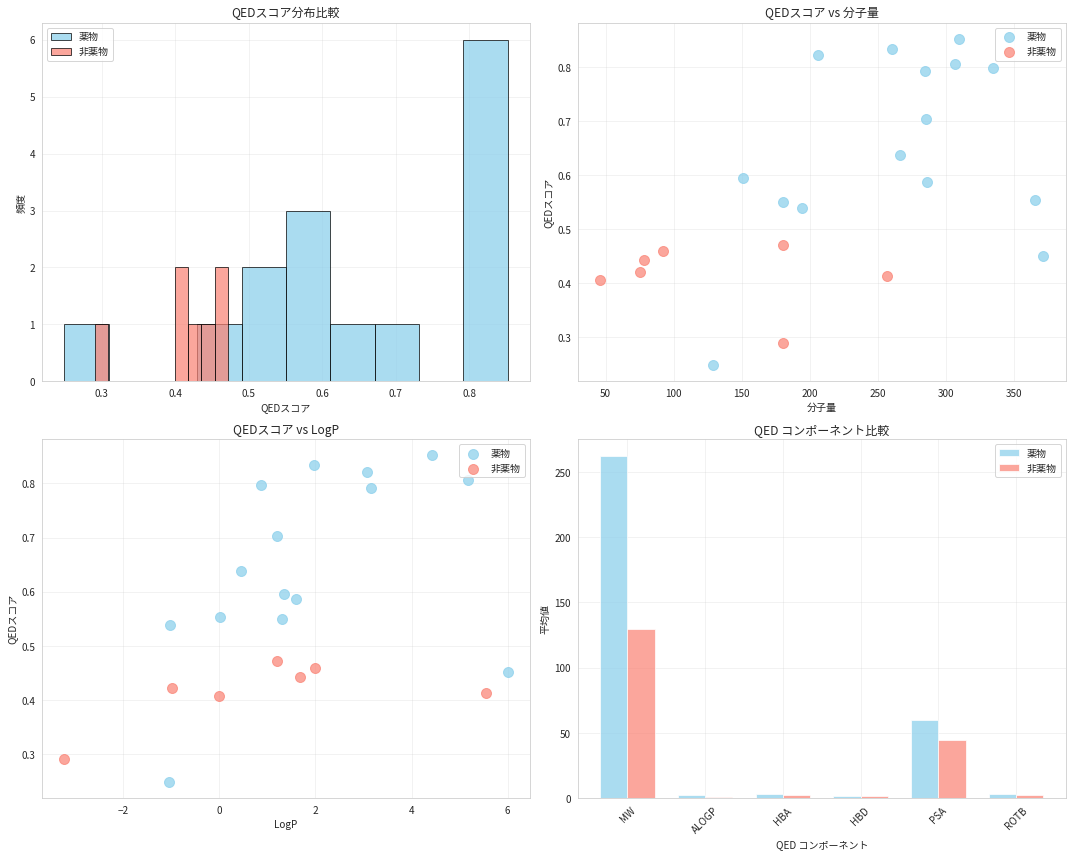


統計情報:
薬物のQEDスコア: 0.651 ± 0.172
非薬物のQEDスコア: 0.415 ± 0.060


In [4]:
def calculate_qed_scores(smiles_list, names):
    """QEDスコアを計算する関数"""
    qed_data = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # QEDスコアの計算
            qed_score = QED.qed(mol)
            
            # QEDの詳細情報
            qed_props = QED.properties(mol)
            
            qed_dict = {
                '化合物名': name,
                'SMILES': smiles,
                'QED_Score': qed_score,
                'QED_MW': qed_props.MW,
                'QED_ALOGP': qed_props.ALOGP,
                'QED_HBA': qed_props.HBA,
                'QED_HBD': qed_props.HBD,
                'QED_PSA': qed_props.PSA,
                'QED_ROTB': qed_props.ROTB,
                'QED_AROM': qed_props.AROM,
                'QED_ALERTS': qed_props.ALERTS,
            }
            qed_data.append(qed_dict)
    
    return pd.DataFrame(qed_data)

# QEDスコアの計算
df_qed = calculate_qed_scores(smiles_list, names_list)

print("QED (Quantitative Estimate of Drug-likeness) 解析:")
print("=" * 60)

# QEDスコアによるソート
df_qed_sorted = df_qed.sort_values('QED_Score', ascending=False)
print("\nQEDスコア順ランキング:")
print("-" * 40)
for _, row in df_qed_sorted.iterrows():
    drug_type = "薬物" if row['化合物名'] in drug_molecules else "非薬物"
    print(f"{row['QED_Score']:.3f} - {row['化合物名']} ({drug_type})")

# QEDスコアの分布可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. QEDスコア分布
drug_qed = df_qed[df_qed['化合物名'].isin(drug_molecules.keys())]['QED_Score']
non_drug_qed = df_qed[df_qed['化合物名'].isin(non_drug_molecules.keys())]['QED_Score']

axes[0, 0].hist(drug_qed, bins=10, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[0, 0].hist(non_drug_qed, bins=10, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[0, 0].set_xlabel('QEDスコア')
axes[0, 0].set_ylabel('頻度')
axes[0, 0].set_title('QEDスコア分布比較')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. QEDスコア vs 分子量
axes[0, 1].scatter(df_qed[df_qed['化合物名'].isin(drug_molecules.keys())]['QED_MW'], 
                  drug_qed, label='薬物', color='skyblue', alpha=0.7, s=100)
axes[0, 1].scatter(df_qed[df_qed['化合物名'].isin(non_drug_molecules.keys())]['QED_MW'], 
                  non_drug_qed, label='非薬物', color='salmon', alpha=0.7, s=100)
axes[0, 1].set_xlabel('分子量')
axes[0, 1].set_ylabel('QEDスコア')
axes[0, 1].set_title('QEDスコア vs 分子量')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. QEDスコア vs LogP
axes[1, 0].scatter(df_qed[df_qed['化合物名'].isin(drug_molecules.keys())]['QED_ALOGP'], 
                  drug_qed, label='薬物', color='skyblue', alpha=0.7, s=100)
axes[1, 0].scatter(df_qed[df_qed['化合物名'].isin(non_drug_molecules.keys())]['QED_ALOGP'], 
                  non_drug_qed, label='非薬物', color='salmon', alpha=0.7, s=100)
axes[1, 0].set_xlabel('LogP')
axes[1, 0].set_ylabel('QEDスコア')
axes[1, 0].set_title('QEDスコア vs LogP')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. QEDコンポーネントの比較
qed_components = ['QED_MW', 'QED_ALOGP', 'QED_HBA', 'QED_HBD', 'QED_PSA', 'QED_ROTB']
drug_means = df_qed[df_qed['化合物名'].isin(drug_molecules.keys())][qed_components].mean()
non_drug_means = df_qed[df_qed['化合物名'].isin(non_drug_molecules.keys())][qed_components].mean()

x = np.arange(len(qed_components))
width = 0.35

axes[1, 1].bar(x - width/2, drug_means, width, label='薬物', color='skyblue', alpha=0.7)
axes[1, 1].bar(x + width/2, non_drug_means, width, label='非薬物', color='salmon', alpha=0.7)
axes[1, 1].set_xlabel('QED コンポーネント')
axes[1, 1].set_ylabel('平均値')
axes[1, 1].set_title('QED コンポーネント比較')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([comp.replace('QED_', '') for comp in qed_components], rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 統計情報
print(f"\n統計情報:")
print(f"薬物のQEDスコア: {drug_qed.mean():.3f} ± {drug_qed.std():.3f}")
print(f"非薬物のQEDスコア: {non_drug_qed.mean():.3f} ± {non_drug_qed.std():.3f}")

## 4. ADMET パラメータの予測

ADMET（Absorption, Distribution, Metabolism, Excretion, Toxicity）は薬物の体内動態と毒性を表すパラメータです。分子記述子から簡易的なADMET予測を行います。

ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) 解析:

薬物分子のADMET評価:
------------------------------------------------------------

アスピリン:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

イブプロフェン:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

パラセタモール:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

ペニシリンG:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

アモキシシリン:
  消化管吸収予測: 良好
  血液脳関門通過: 困難
  肝毒性リスク: なし
  バイオアベイラビリティ: 0.68

プロプラノロール:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

アテノロール:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

モルヒネ:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

カフェイン:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

ジアゼパム:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

ドキソルビシン:
  消化管吸収予測: 良好
  血液脳関門通過: 困難
  肝毒性リスク: なし
  バイオアベイラビリティ: 1.00

タモキシフェン:
  消化管吸収予測: 良好
  血液脳関門通過: 可能
  肝毒性リスク: なし
  バイオアベイラビリティ: 0.21

メトホルミン:
  消

[17:16:53] SMILES Parse Error: syntax error while parsing: GIVEQCCTSICSLYQLENYCN
[17:16:53] SMILES Parse Error: check for mistakes around position 1:
[17:16:53] GIVEQCCTSICSLYQLENYCN
[17:16:53] ^
[17:16:53] SMILES Parse Error: Failed parsing SMILES 'GIVEQCCTSICSLYQLENYCN' for input: 'GIVEQCCTSICSLYQLENYCN'


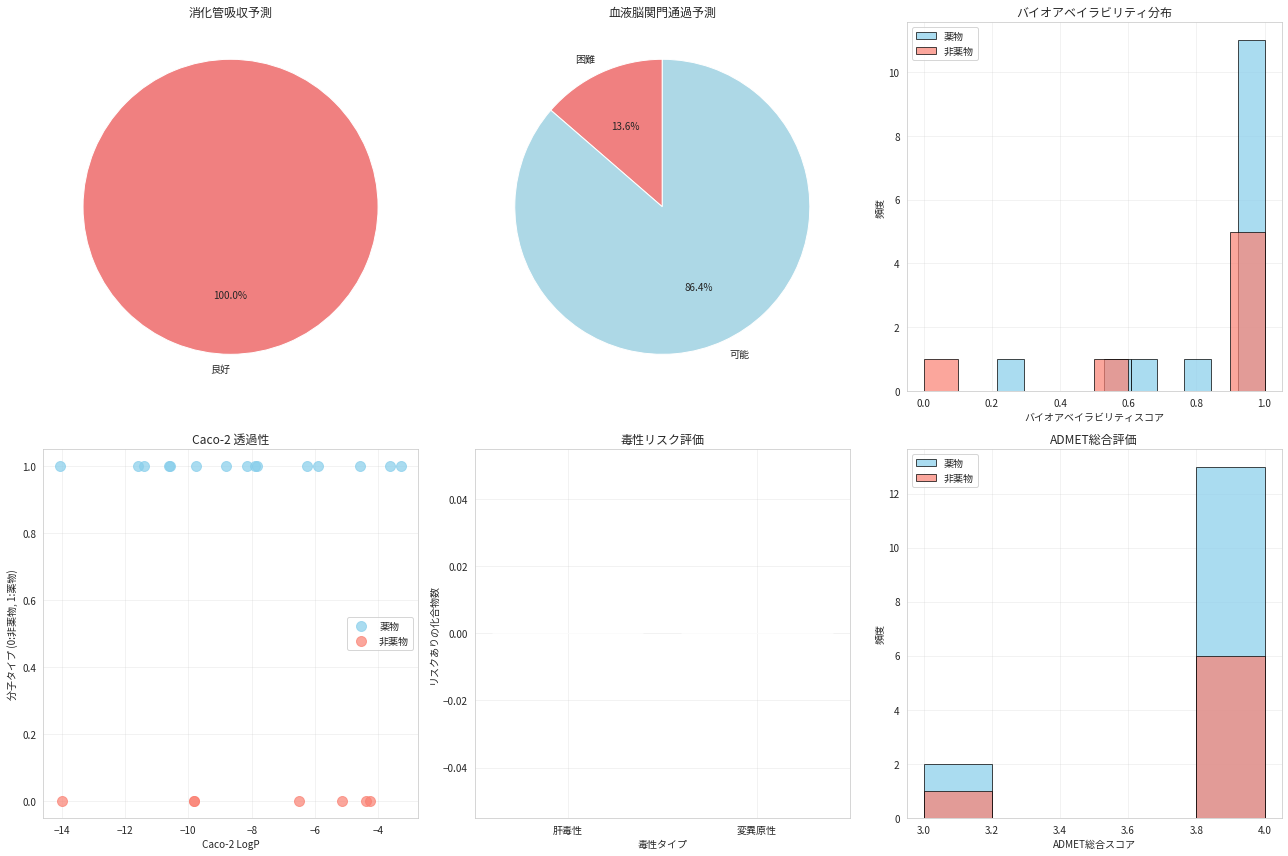


ADMET統計:
薬物のADMET平均スコア: 3.87 ± 0.35
非薬物のADMET平均スコア: 3.86 ± 0.38


In [5]:
def calculate_admet_properties(smiles_list, names):
    """ADMET関連パラメータを計算する関数"""
    admet_data = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # 基本記述子
            mw = Descriptors.MolWt(mol)
            logp = Descriptors.MolLogP(mol)
            tpsa = Descriptors.TPSA(mol)
            hbd = Descriptors.NumHDonors(mol)
            hba = Descriptors.NumHAcceptors(mol)
            rotb = Descriptors.NumRotatableBonds(mol)
            
            # ADMET予測（経験式ベース）
            admet_dict = {
                '化合物名': name,
                'SMILES': smiles,
                
                # Absorption（吸収）
                'HIA_Prediction': 1 if (tpsa <= 140 and mw <= 500) else 0,  # Human Intestinal Absorption
                'Caco2_LogP': -5.15 + 0.45 * logp - 0.067 * tpsa,  # Caco-2 透過性
                
                # Distribution（分布）
                'BBB_Prediction': 1 if (tpsa <= 90 and mw <= 450) else 0,  # Blood-Brain Barrier
                'LogD74': logp - 0.74 * tpsa / 100,  # pH 7.4での分配係数
                
                # Metabolism（代謝）
                'CYP_Substrate': 1 if (300 <= mw <= 1000 and -1 <= logp <= 5) else 0,
                
                # Excretion（排泄）
                'Renal_Clearance': max(0, 10 - 0.01 * mw - 0.5 * logp),  # 簡易推定
                
                # Toxicity（毒性）
                'Hepatotoxicity_Risk': 1 if (logp > 3 and mw > 400) else 0,
                'Mutagenicity_Risk': 1 if (Descriptors.NumAromaticRings(mol) > 3) else 0,
                
                # 全般的な薬物動態
                'Bioavailability_Score': max(0, min(1, (500 - mw) / 200 * (5 - abs(logp - 2)) / 3)),
            }
            admet_data.append(admet_dict)
    
    return pd.DataFrame(admet_data)

# ADMET解析
df_admet = calculate_admet_properties(smiles_list, names_list)

print("ADMET (Absorption, Distribution, Metabolism, Excretion, Toxicity) 解析:")
print("=" * 80)

# 薬物分子のADMET評価
drug_admet = df_admet[df_admet['化合物名'].isin(drug_molecules.keys())]
print("\n薬物分子のADMET評価:")
print("-" * 60)
for _, row in drug_admet.iterrows():
    print(f"\n{row['化合物名']}:")
    print(f"  消化管吸収予測: {'良好' if row['HIA_Prediction'] else '不良'}")
    print(f"  血液脳関門通過: {'可能' if row['BBB_Prediction'] else '困難'}")
    print(f"  肝毒性リスク: {'あり' if row['Hepatotoxicity_Risk'] else 'なし'}")
    print(f"  バイオアベイラビリティ: {row['Bioavailability_Score']:.2f}")

# ADMET特性の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 消化管吸収予測
hia_counts = df_admet.groupby(['HIA_Prediction'])['化合物名'].count()
hia_labels = ['不良' if idx == 0 else '良好' for idx in hia_counts.index]
axes[0, 0].pie(hia_counts.values, labels=hia_labels, autopct='%1.1f%%', 
               colors=['lightcoral', 'lightblue'], startangle=90)
axes[0, 0].set_title('消化管吸収予測')

# 2. 血液脳関門通過予測
bbb_counts = df_admet.groupby(['BBB_Prediction'])['化合物名'].count()
bbb_labels = ['困難' if idx == 0 else '可能' for idx in bbb_counts.index]
axes[0, 1].pie(bbb_counts.values, labels=bbb_labels, autopct='%1.1f%%', 
               colors=['lightcoral', 'lightblue'], startangle=90)
axes[0, 1].set_title('血液脳関門通過予測')

# 3. バイオアベイラビリティスコア分布
drug_ba = df_admet[df_admet['化合物名'].isin(drug_molecules.keys())]['Bioavailability_Score']
non_drug_ba = df_admet[df_admet['化合物名'].isin(non_drug_molecules.keys())]['Bioavailability_Score']

axes[0, 2].hist(drug_ba, bins=10, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[0, 2].hist(non_drug_ba, bins=10, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[0, 2].set_xlabel('バイオアベイラビリティスコア')
axes[0, 2].set_ylabel('頻度')
axes[0, 2].set_title('バイオアベイラビリティ分布')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Caco-2透過性 vs LogP
axes[1, 0].scatter(df_admet[df_admet['化合物名'].isin(drug_molecules.keys())]['Caco2_LogP'], 
                  [1] * len(drug_ba), label='薬物', color='skyblue', alpha=0.7, s=100)
axes[1, 0].scatter(df_admet[df_admet['化合物名'].isin(non_drug_molecules.keys())]['Caco2_LogP'], 
                  [0] * len(non_drug_ba), label='非薬物', color='salmon', alpha=0.7, s=100)
axes[1, 0].set_xlabel('Caco-2 LogP')
axes[1, 0].set_ylabel('分子タイプ (0:非薬物, 1:薬物)')
axes[1, 0].set_title('Caco-2 透過性')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 毒性リスク評価
toxicity_data = df_admet[['Hepatotoxicity_Risk', 'Mutagenicity_Risk']].sum()
axes[1, 1].bar(range(len(toxicity_data)), toxicity_data.values, 
               color=['orange', 'red'], alpha=0.7)
axes[1, 1].set_xlabel('毒性タイプ')
axes[1, 1].set_ylabel('リスクありの化合物数')
axes[1, 1].set_title('毒性リスク評価')
axes[1, 1].set_xticks(range(len(toxicity_data)))
axes[1, 1].set_xticklabels(['肝毒性', '変異原性'])
axes[1, 1].grid(True, alpha=0.3)

# 6. ADMET総合評価
admet_score = df_admet['HIA_Prediction'] + df_admet['BBB_Prediction'] + \
              (1 - df_admet['Hepatotoxicity_Risk']) + (1 - df_admet['Mutagenicity_Risk'])
df_admet['ADMET_Score'] = admet_score

drug_admet_scores = df_admet[df_admet['化合物名'].isin(drug_molecules.keys())]['ADMET_Score']
non_drug_admet_scores = df_admet[df_admet['化合物名'].isin(non_drug_molecules.keys())]['ADMET_Score']

axes[1, 2].hist(drug_admet_scores, bins=5, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[1, 2].hist(non_drug_admet_scores, bins=5, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[1, 2].set_xlabel('ADMET総合スコア')
axes[1, 2].set_ylabel('頻度')
axes[1, 2].set_title('ADMET総合評価')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nADMET統計:")
print(f"薬物のADMET平均スコア: {drug_admet_scores.mean():.2f} ± {drug_admet_scores.std():.2f}")
print(f"非薬物のADMET平均スコア: {non_drug_admet_scores.mean():.2f} ± {non_drug_admet_scores.std():.2f}")

## 5. 構造アラートとフィルタリング

特定の部分構造は毒性や副作用と関連があることが知られています。これらの「構造アラート」を検出する手法を学習します。

構造アラート解析:

構造アラートを持つ化合物:
----------------------------------------
ペニシリンG (薬物):
  PAINS: 0, 反応性: 0, 不安定: 0, 毒性: 1
アモキシシリン (薬物):
  PAINS: 0, 反応性: 0, 不安定: 0, 毒性: 1

クリーンな化合物数: 21/23


[17:16:54] SMILES Parse Error: syntax error while parsing: GIVEQCCTSICSLYQLENYCN
[17:16:54] SMILES Parse Error: check for mistakes around position 1:
[17:16:54] GIVEQCCTSICSLYQLENYCN
[17:16:54] ^
[17:16:54] SMILES Parse Error: Failed parsing SMILES 'GIVEQCCTSICSLYQLENYCN' for input: 'GIVEQCCTSICSLYQLENYCN'


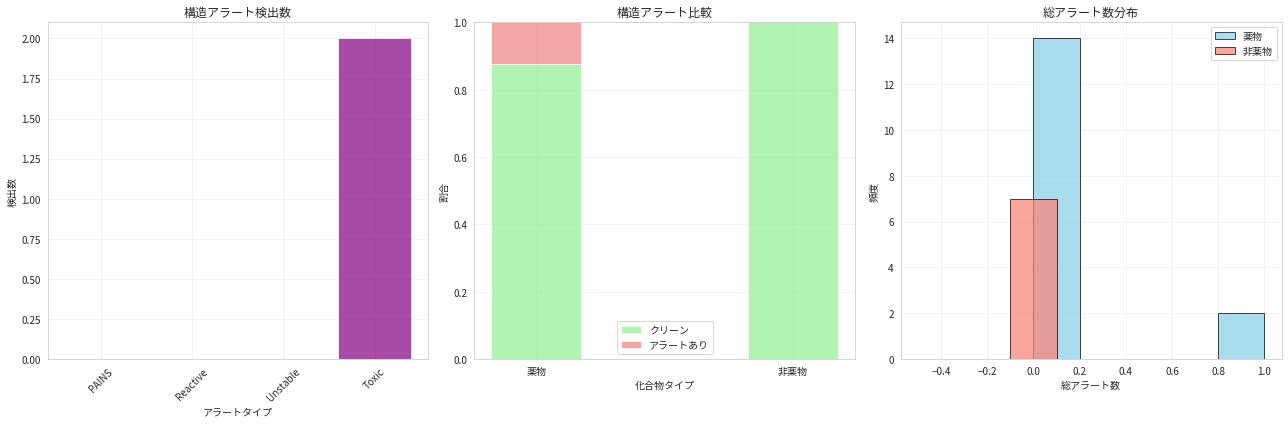

In [6]:
# 構造アラートの定義（PAINS, REOS等）
def check_structural_alerts(mol):
    """構造アラートをチェックする関数"""
    alerts = {
        'PAINS': 0,  # Pan Assay Interference Compounds
        'Reactive': 0,  # 反応性化合物
        'Unstable': 0,  # 不安定化合物
        'Toxic': 0  # 毒性化合物
    }
    
    if mol is None:
        return alerts
    
    # PAINS パターン（簡易版）
    pains_patterns = [
        # キノン様構造
        Chem.MolFromSmarts('[#6]1:[#6]:[#6]:[#6](=[O,S]):[#6]:[#6]:1'),
        # アルデヒド
        Chem.MolFromSmarts('[CX3H1](=O)'),
        # 反応性ケトン
        Chem.MolFromSmarts('[#6](=[O])[#6](=[O])'),
    ]
    
    # 反応性パターン
    reactive_patterns = [
        # ハロゲン化アルキル
        Chem.MolFromSmarts('[C][Cl,Br,I]'),
        # エポキシド
        Chem.MolFromSmarts('[C]1[O][C]1'),
        # アクリルアミド
        Chem.MolFromSmarts('[C]=[C][C](=O)[N]'),
    ]
    
    # 不安定パターン
    unstable_patterns = [
        # ペルオキシド
        Chem.MolFromSmarts('[O][O]'),
        # ニトロソ
        Chem.MolFromSmarts('[N]=[O]'),
    ]
    
    # 毒性パターン
    toxic_patterns = [
        # ニトロ化合物
        Chem.MolFromSmarts('[N+](=O)[O-]'),
        # 重金属結合サイト
        Chem.MolFromSmarts('[#16]'),  # 硫黄（簡易）
    ]
    
    # パターンマッチング
    for pattern in pains_patterns:
        if pattern and mol.HasSubstructMatch(pattern):
            alerts['PAINS'] += 1
    
    for pattern in reactive_patterns:
        if pattern and mol.HasSubstructMatch(pattern):
            alerts['Reactive'] += 1
    
    for pattern in unstable_patterns:
        if pattern and mol.HasSubstructMatch(pattern):
            alerts['Unstable'] += 1
    
    for pattern in toxic_patterns:
        if pattern and mol.HasSubstructMatch(pattern):
            alerts['Toxic'] += 1
    
    return alerts

def analyze_structural_alerts(smiles_list, names):
    """構造アラート解析"""
    alert_data = []
    
    for name, smiles in zip(names, smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        alerts = check_structural_alerts(mol)
        
        alert_dict = {
            '化合物名': name,
            'SMILES': smiles,
            **alerts,
            'Total_Alerts': sum(alerts.values()),
            'Clean_Compound': sum(alerts.values()) == 0
        }
        alert_data.append(alert_dict)
    
    return pd.DataFrame(alert_data)

# 構造アラート解析
df_alerts = analyze_structural_alerts(smiles_list, names_list)

print("構造アラート解析:")
print("=" * 50)

# アラートありの化合物
alert_compounds = df_alerts[df_alerts['Total_Alerts'] > 0]
if len(alert_compounds) > 0:
    print("\n構造アラートを持つ化合物:")
    print("-" * 40)
    for _, row in alert_compounds.iterrows():
        drug_type = "薬物" if row['化合物名'] in drug_molecules else "非薬物"
        print(f"{row['化合物名']} ({drug_type}):")
        print(f"  PAINS: {row['PAINS']}, 反応性: {row['Reactive']}, 不安定: {row['Unstable']}, 毒性: {row['Toxic']}")
else:
    print("構造アラートを持つ化合物は検出されませんでした")

# クリーンな化合物
clean_compounds = df_alerts[df_alerts['Clean_Compound']]
print(f"\nクリーンな化合物数: {len(clean_compounds)}/{len(df_alerts)}")

# 可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. アラート分布
alert_types = ['PAINS', 'Reactive', 'Unstable', 'Toxic']
alert_counts = [df_alerts[alert_type].sum() for alert_type in alert_types]

axes[0].bar(range(len(alert_types)), alert_counts, color=['red', 'orange', 'yellow', 'purple'], alpha=0.7)
axes[0].set_xlabel('アラートタイプ')
axes[0].set_ylabel('検出数')
axes[0].set_title('構造アラート検出数')
axes[0].set_xticks(range(len(alert_types)))
axes[0].set_xticklabels(alert_types, rotation=45)
axes[0].grid(True, alpha=0.3)

# 2. 薬物 vs 非薬物のアラート比較
drug_clean = len(df_alerts[(df_alerts['化合物名'].isin(drug_molecules.keys())) & 
                          (df_alerts['Clean_Compound'])])
drug_total = len(df_alerts[df_alerts['化合物名'].isin(drug_molecules.keys())])
non_drug_clean = len(df_alerts[(df_alerts['化合物名'].isin(non_drug_molecules.keys())) & 
                              (df_alerts['Clean_Compound'])])
non_drug_total = len(df_alerts[df_alerts['化合物名'].isin(non_drug_molecules.keys())])

categories = ['薬物', '非薬物']
clean_ratios = [drug_clean/drug_total, non_drug_clean/non_drug_total]
alert_ratios = [1-drug_clean/drug_total, 1-non_drug_clean/non_drug_total]

width = 0.35
x = np.arange(len(categories))

axes[1].bar(x, clean_ratios, width, label='クリーン', color='lightgreen', alpha=0.7)
axes[1].bar(x, alert_ratios, width, bottom=clean_ratios, label='アラートあり', color='lightcoral', alpha=0.7)
axes[1].set_xlabel('化合物タイプ')
axes[1].set_ylabel('割合')
axes[1].set_title('構造アラート比較')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. トータルアラート数分布
drug_alerts = df_alerts[df_alerts['化合物名'].isin(drug_molecules.keys())]['Total_Alerts']
non_drug_alerts = df_alerts[df_alerts['化合物名'].isin(non_drug_molecules.keys())]['Total_Alerts']

axes[2].hist(drug_alerts, bins=5, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[2].hist(non_drug_alerts, bins=5, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[2].set_xlabel('総アラート数')
axes[2].set_ylabel('頻度')
axes[2].set_title('総アラート数分布')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. 機械学習による薬物・非薬物分類

計算した記述子を用いて、機械学習モデルで薬物と非薬物を分類する手法を学習します。

機械学習による薬物・非薬物分類:
特徴量数: 17
サンプル数: 22
薬物: 15個, 非薬物: 7個

分類結果:
------------------------------
Classification Report:
              precision    recall  f1-score   support

         非薬物       0.33      0.50      0.40         2
          薬物       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7


混同行列:
[[1 1]
 [2 3]]

特徴量重要度 (上位10位):
          Feature  Importance
0             分子量    0.192701
1     Heavy_Atoms    0.181343
13          MolMR    0.165559
14      QED_Score    0.153368
10        BertzCT    0.096474
5            TPSA    0.042939
2            LogP    0.041389
7       RingCount    0.040413
3             HBD    0.023538
8   AromaticRings    0.021270


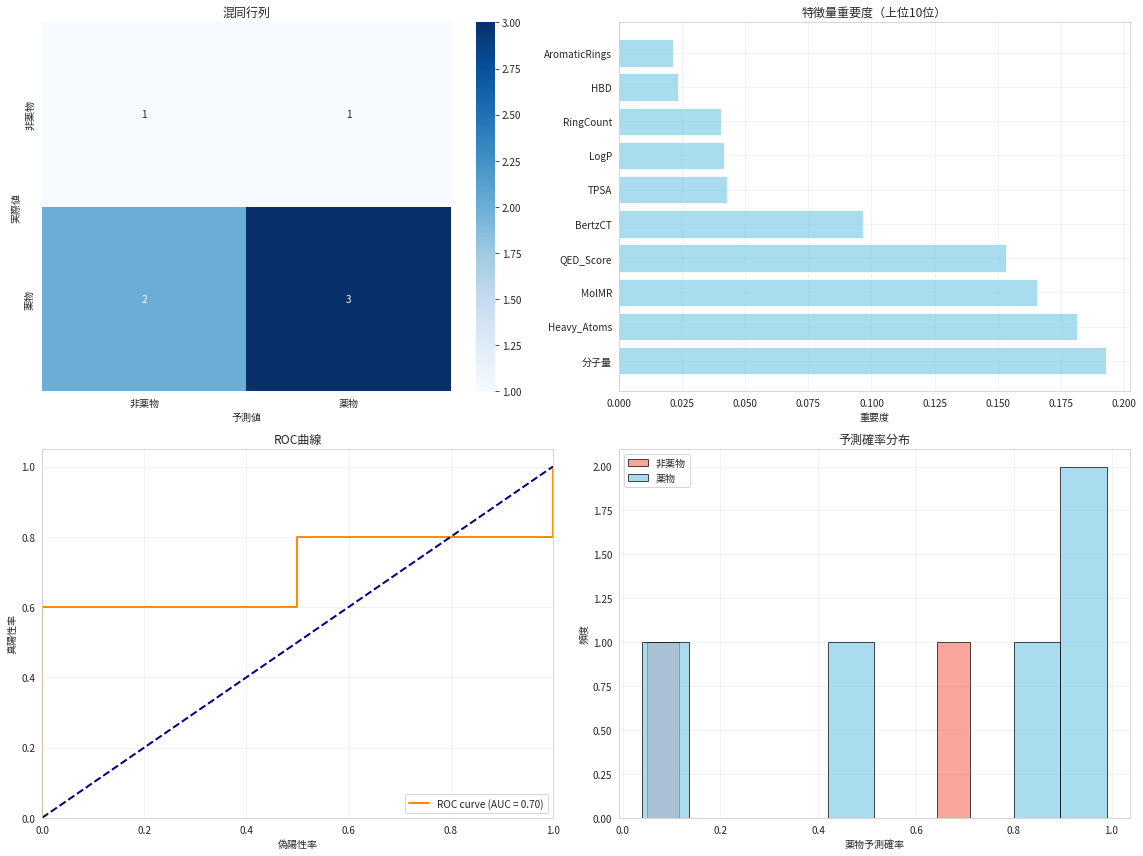


モデル性能:
AUC: 0.700
精度: 0.571


In [7]:
# 機械学習用のデータ準備
def prepare_ml_data():
    """機械学習用のデータを準備"""
    
    # データの結合
    df_combined = df_descriptors.copy()
    
    # ラベルの追加（薬物=1, 非薬物=0）
    df_combined['is_drug'] = df_combined['化合物名'].apply(
        lambda x: 1 if x in drug_molecules else 0
    )
    
    # QEDスコアの追加
    qed_scores = df_qed.set_index('化合物名')['QED_Score']
    df_combined['QED_Score'] = df_combined['化合物名'].map(qed_scores)
    
    # ADMETスコアの追加
    admet_scores = df_admet.set_index('化合物名')['ADMET_Score']
    df_combined['ADMET_Score'] = df_combined['化合物名'].map(admet_scores)
    
    # アラートスコアの追加
    alert_scores = df_alerts.set_index('化合物名')['Total_Alerts']
    df_combined['Total_Alerts'] = df_combined['化合物名'].map(alert_scores)
    
    # 特徴量の選択（数値のみ）
    feature_columns = [
        '分子量', 'Heavy_Atoms', 'LogP', 'HBD', 'HBA', 'TPSA', 'RotBonds',
        'RingCount', 'AromaticRings', 'Aliphatic_Rings', 'BertzCT',
        'FractionCsp3', 'NumHeteroatoms', 'MolMR', 'QED_Score', 
        'ADMET_Score', 'Total_Alerts'
    ]
    
    X = df_combined[feature_columns].fillna(0)
    y = df_combined['is_drug']
    
    return X, y, feature_columns, df_combined

# データ準備
X, y, feature_columns, df_ml = prepare_ml_data()

print("機械学習による薬物・非薬物分類:")
print("=" * 50)
print(f"特徴量数: {len(feature_columns)}")
print(f"サンプル数: {len(X)}")
print(f"薬物: {y.sum()}個, 非薬物: {len(y) - y.sum()}個")

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 特徴量の標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forestモデルの学習
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train_scaled, y_train)

# 予測
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# 評価
print("\n分類結果:")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['非薬物', '薬物']))

# 混同行列
cm = confusion_matrix(y_test, y_pred)
print("\n混同行列:")
print(cm)

# 特徴量重要度
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n特徴量重要度 (上位10位):")
print(feature_importance.head(10))

# 可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 混同行列
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['非薬物', '薬物'], yticklabels=['非薬物', '薬物'], ax=axes[0, 0])
axes[0, 0].set_title('混同行列')
axes[0, 0].set_xlabel('予測値')
axes[0, 0].set_ylabel('実際値')

# 2. 特徴量重要度
top_features = feature_importance.head(10)
axes[0, 1].barh(range(len(top_features)), top_features['Importance'], color='skyblue', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels(top_features['Feature'])
axes[0, 1].set_xlabel('重要度')
axes[0, 1].set_title('特徴量重要度（上位10位）')
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC曲線
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('偽陽性率')
axes[1, 0].set_ylabel('真陽性率')
axes[1, 0].set_title('ROC曲線')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# 4. 予測確率分布
drug_proba = y_pred_proba[y_test == 1]
non_drug_proba = y_pred_proba[y_test == 0]

axes[1, 1].hist(non_drug_proba, bins=10, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[1, 1].hist(drug_proba, bins=10, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('薬物予測確率')
axes[1, 1].set_ylabel('頻度')
axes[1, 1].set_title('予測確率分布')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nモデル性能:")
print(f"AUC: {roc_auc:.3f}")
print(f"精度: {(y_pred == y_test).mean():.3f}")

## 7. 薬らしさスコアの統合評価

これまで計算した各種指標を統合して、包括的な薬らしさスコアを作成します。

統合薬らしさスコア:

統合薬らしさスコア ランキング:
--------------------------------------------------
 1. 0.956 - フルオキセチン (薬物)
 2. 0.950 - プロプラノロール (薬物)
 3. 0.946 - イブプロフェン (薬物)
 4. 0.937 - ジアゼパム (薬物)
 5. 0.911 - モルヒネ (薬物)
 6. 0.899 - ペニシリンG (薬物)
 7. 0.891 - アテノロール (薬物)
 8. 0.879 - セルトラリン (薬物)
 9. 0.879 - パラセタモール (薬物)
10. 0.865 - アスピリン (薬物)
11. 0.862 - カフェイン (薬物)
12. 0.841 - カフェイン酸 (非薬物)
13. 0.838 - トルエン (非薬物)
14. 0.833 - ベンゼン (非薬物)
15. 0.826 - アミノ酸_グリシン (非薬物)
16. 0.822 - エタノール (非薬物)
17. 0.814 - ドキソルビシン (薬物)
18. 0.775 - メトホルミン (薬物)
19. 0.773 - タモキシフェン (薬物)
20. 0.763 - アモキシシリン (薬物)
21. 0.762 - 脂肪酸_パルミチン酸 (非薬物)
22. 0.725 - グルコース (非薬物)

スコア成分詳細（上位5位）:
------------------------------------------------------------

フルオキセチン:
  統合スコア: 0.956
  QED: 0.852
  ADMET: 1.000
  Lipinski: 1.000
  Alerts: 1.000

プロプラノロール:
  統合スコア: 0.950
  QED: 0.834
  ADMET: 1.000
  Lipinski: 1.000
  Alerts: 1.000

イブプロフェン:
  統合スコア: 0.946
  QED: 0.822
  ADMET: 1.000
  Lipinski: 1.000
  Alerts: 1.000

ジアゼパム:
  統合スコア: 0.937
  QED: 0.792
  ADME

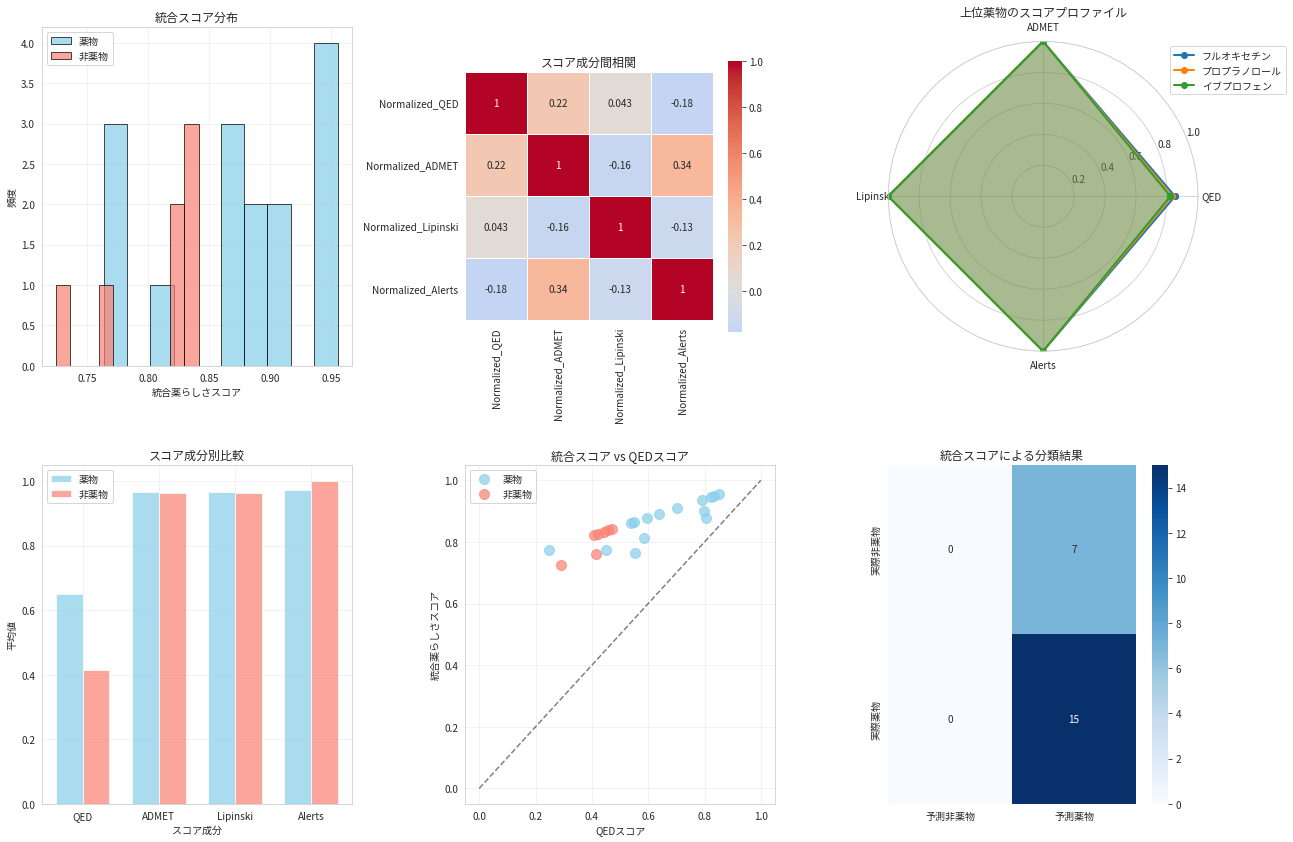


統合スコア分類性能 (閾値: 0.5):
精度: 0.682
適合率: 0.682
再現率: 1.000
F1スコア: 0.811

統計情報:
薬物の統合スコア: 0.873 ± 0.066
非薬物の統合スコア: 0.807 ± 0.045


In [8]:
def create_integrated_druglikeness_score(df_combined):
    """統合薬らしさスコアの作成"""
    df_score = df_combined.copy()
    
    # 各スコアの正規化（0-1スケール）
    df_score['Normalized_QED'] = df_score['QED_Score']  # 既に0-1
    df_score['Normalized_ADMET'] = df_score['ADMET_Score'] / 4  # 0-4 → 0-1
    df_score['Normalized_Alerts'] = 1 - np.clip(df_score['Total_Alerts'] / 5, 0, 1)  # アラート数が多いほど低スコア
    
    # Lipinskiスコアの計算
    lipinski_data = evaluate_lipinski_extended(df_score)
    df_score['Normalized_Lipinski'] = lipinski_data['Lipinski_Score'] / 4
    
    # 重み付け統合スコア
    weights = {
        'QED': 0.3,
        'ADMET': 0.25,
        'Lipinski': 0.25,
        'Alerts': 0.2
    }
    
    df_score['Integrated_Score'] = (
        weights['QED'] * df_score['Normalized_QED'] +
        weights['ADMET'] * df_score['Normalized_ADMET'] +
        weights['Lipinski'] * df_score['Normalized_Lipinski'] +
        weights['Alerts'] * df_score['Normalized_Alerts']
    )
    
    return df_score

# 統合スコアの計算
df_integrated = create_integrated_druglikeness_score(df_ml)

print("統合薬らしさスコア:")
print("=" * 60)

# スコア順ランキング
ranking = df_integrated.sort_values('Integrated_Score', ascending=False)
print("\n統合薬らしさスコア ランキング:")
print("-" * 50)
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    drug_type = "薬物" if row['is_drug'] else "非薬物"
    print(f"{i:2d}. {row['Integrated_Score']:.3f} - {row['化合物名']} ({drug_type})")

# スコア成分の詳細表示
print("\nスコア成分詳細（上位5位）:")
print("-" * 60)
for _, row in ranking.head().iterrows():
    print(f"\n{row['化合物名']}:")
    print(f"  統合スコア: {row['Integrated_Score']:.3f}")
    print(f"  QED: {row['Normalized_QED']:.3f}")
    print(f"  ADMET: {row['Normalized_ADMET']:.3f}")
    print(f"  Lipinski: {row['Normalized_Lipinski']:.3f}")
    print(f"  Alerts: {row['Normalized_Alerts']:.3f}")

# 可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 統合スコア分布
drug_scores = df_integrated[df_integrated['is_drug'] == 1]['Integrated_Score']
non_drug_scores = df_integrated[df_integrated['is_drug'] == 0]['Integrated_Score']

axes[0, 0].hist(drug_scores, bins=10, alpha=0.7, label='薬物', color='skyblue', edgecolor='black')
axes[0, 0].hist(non_drug_scores, bins=10, alpha=0.7, label='非薬物', color='salmon', edgecolor='black')
axes[0, 0].set_xlabel('統合薬らしさスコア')
axes[0, 0].set_ylabel('頻度')
axes[0, 0].set_title('統合スコア分布')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. スコア成分の相関
score_components = ['Normalized_QED', 'Normalized_ADMET', 'Normalized_Lipinski', 'Normalized_Alerts']
corr_matrix = df_integrated[score_components].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, ax=axes[0, 1])
axes[0, 1].set_title('スコア成分間相関')

# 3. レーダーチャート（上位薬物）
top_drugs = df_integrated[df_integrated['is_drug'] == 1].nlargest(3, 'Integrated_Score')

angles = np.linspace(0, 2 * np.pi, len(score_components), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

axes[0, 2] = plt.subplot(2, 3, 3, projection='polar')
for _, drug in top_drugs.iterrows():
    values = drug[score_components].values
    values = np.concatenate((values, [values[0]]))
    axes[0, 2].plot(angles, values, 'o-', linewidth=2, label=drug['化合物名'][:8])
    axes[0, 2].fill(angles, values, alpha=0.25)

axes[0, 2].set_xticks(angles[:-1])
axes[0, 2].set_xticklabels(['QED', 'ADMET', 'Lipinski', 'Alerts'])
axes[0, 2].set_ylim(0, 1)
axes[0, 2].set_title('上位薬物のスコアプロファイル')
axes[0, 2].legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 4. 各成分別の薬物 vs 非薬物比較
component_means_drug = df_integrated[df_integrated['is_drug'] == 1][score_components].mean()
component_means_non_drug = df_integrated[df_integrated['is_drug'] == 0][score_components].mean()

x = np.arange(len(score_components))
width = 0.35

axes[1, 0].bar(x - width/2, component_means_drug, width, label='薬物', color='skyblue', alpha=0.7)
axes[1, 0].bar(x + width/2, component_means_non_drug, width, label='非薬物', color='salmon', alpha=0.7)
axes[1, 0].set_xlabel('スコア成分')
axes[1, 0].set_ylabel('平均値')
axes[1, 0].set_title('スコア成分別比較')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['QED', 'ADMET', 'Lipinski', 'Alerts'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. 統合スコア vs QEDスコア
axes[1, 1].scatter(df_integrated[df_integrated['is_drug'] == 1]['QED_Score'], 
                  drug_scores, label='薬物', color='skyblue', alpha=0.7, s=100)
axes[1, 1].scatter(df_integrated[df_integrated['is_drug'] == 0]['QED_Score'], 
                  non_drug_scores, label='非薬物', color='salmon', alpha=0.7, s=100)
axes[1, 1].set_xlabel('QEDスコア')
axes[1, 1].set_ylabel('統合薬らしさスコア')
axes[1, 1].set_title('統合スコア vs QEDスコア')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 対角線を描画
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)

# 6. 薬らしさ分類結果
threshold = 0.5
predicted_drugs = df_integrated['Integrated_Score'] >= threshold
actual_drugs = df_integrated['is_drug'] == 1

tp = np.sum(predicted_drugs & actual_drugs)
fp = np.sum(predicted_drugs & ~actual_drugs)
tn = np.sum(~predicted_drugs & ~actual_drugs)
fn = np.sum(~predicted_drugs & actual_drugs)

confusion_data = np.array([[tn, fp], [fn, tp]])
sns.heatmap(confusion_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=['予測非薬物', '予測薬物'], 
            yticklabels=['実際非薬物', '実際薬物'], ax=axes[1, 2])
axes[1, 2].set_title('統合スコアによる分類結果')

plt.tight_layout()
plt.show()

# 分類性能の評価
accuracy = (tp + tn) / (tp + fp + tn + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n統合スコア分類性能 (閾値: {threshold}):")
print(f"精度: {accuracy:.3f}")
print(f"適合率: {precision:.3f}")
print(f"再現率: {recall:.3f}")
print(f"F1スコア: {f1:.3f}")

print(f"\n統計情報:")
print(f"薬物の統合スコア: {drug_scores.mean():.3f} ± {drug_scores.std():.3f}")
print(f"非薬物の統合スコア: {non_drug_scores.mean():.3f} ± {non_drug_scores.std():.3f}")

## まとめ

本ノートブックでは、記述子による薬らしさの表現について包括的に学習しました：

### 主要なポイント

1. **基本的な薬物記述子**:
   - 分子量、LogP、TPSA、水素結合数など
   - 物理化学的性質の数値化

2. **Lipinski's Rule of Five**:
   - 経口薬物の基本的な判定基準
   - 拡張ルールとLead-like基準

3. **QED (Quantitative Estimate of Drug-likeness)**:
   - 複数記述子を統合した薬らしさ評価
   - 0-1スケールでの定量化

4. **ADMET パラメータ**:
   - 吸収・分布・代謝・排泄・毒性の予測
   - 薬物動態の初期評価

5. **構造アラート**:
   - PAINS、反応性、毒性パターンの検出
   - 好ましくない部分構造の特定

6. **機械学習による分類**:
   - 薬物・非薬物の自動判別
   - 特徴量重要度の分析

7. **統合薬らしさスコア**:
   - 複数指標の重み付け統合
   - 包括的な薬らしさ評価

### 創薬への応用

- **初期スクリーニング**: 薬らしさフィルタによる候補化合物の絞り込み
- **リード最適化**: 記述子を指標とした構造修飾
- **バーチャルライブラリ設計**: 薬らしさを考慮した合成計画
- **開発可能性評価**: ADMET予測による開発リスク評価

### 次のステップ

1. より高精度なADMET予測モデルの構築
2. 疾患特異的な薬らしさ基準の開発
3. 3D構造を考慮した薬らしさ評価
4. AI創薬における薬らしさ制約の組み込み

In [9]:
# 最終統計情報
plt.rcParams['font.family'] = "Noto Sans CJK JP"

print("記述子による薬らしさ表現学習の統計情報:")
print("=" * 60)
print(f"解析化合物数: {len(df_integrated)}")
print(f"薬物: {df_integrated['is_drug'].sum()}個")
print(f"非薬物: {len(df_integrated) - df_integrated['is_drug'].sum()}個")
print(f"計算記述子数: {len(feature_columns)}")

print("\n各指標の平均値:")
print("-" * 40)
print(f"QEDスコア: {df_integrated['Normalized_QED'].mean():.3f}")
print(f"ADMETスコア: {df_integrated['Normalized_ADMET'].mean():.3f}")
print(f"Lipinskiスコア: {df_integrated['Normalized_Lipinski'].mean():.3f}")
print(f"構造アラート（逆数）: {df_integrated['Normalized_Alerts'].mean():.3f}")
print(f"統合薬らしさスコア: {df_integrated['Integrated_Score'].mean():.3f}")

print("\n手法の特徴:")
print("-" * 30)
print("• Lipinski's Rule: 経口薬物の基本判定基準")
print("• QED: 複数記述子の統合評価")
print("• ADMET: 薬物動態・毒性予測")
print("• 構造アラート: 望ましくない部分構造の検出")
print("• 機械学習: データ駆動型の薬らしさ判定")
print("• 統合スコア: 包括的な薬らしさ定量化")

print("\n学習が完了しました！")

記述子による薬らしさ表現学習の統計情報:
解析化合物数: 22
薬物: 15個
非薬物: 7個
計算記述子数: 17

各指標の平均値:
----------------------------------------
QEDスコア: 0.576
ADMETスコア: 0.966
Lipinskiスコア: 0.966
構造アラート（逆数）: 0.982
統合薬らしさスコア: 0.852

手法の特徴:
------------------------------
• Lipinski's Rule: 経口薬物の基本判定基準
• QED: 複数記述子の統合評価
• ADMET: 薬物動態・毒性予測
• 構造アラート: 望ましくない部分構造の検出
• 機械学習: データ駆動型の薬らしさ判定
• 統合スコア: 包括的な薬らしさ定量化

学習が完了しました！


## 補助資料

### ダウンロード

- <a class="link" href="/files/drug_likeness_descriptors_executed.ipynb" download>実行済みJupyter Notebook (.ipynb)</a>